# ## Some ideas for a numerical solution to the SPACE model: Stream Power with Alluvium Conservation and Entrainment

## Using a local analytical solution for H at each node at each time step

Basic equation set so far, for 1D. Sediment flux downstream:

$$\frac{dq_s}{dx} = K_s q S (1-\exp (-H/H_* ) ) + (1-F_f) K_r q S \exp (-H/H_*) -Vq_s/q$$

Rate of change of alluv thickness:

$$(1-\phi ) \frac{\partial H}{\partial t} = V q_s/q - K_s q S (1-\exp (-H/H_* ) )$$

Rate of change of rock elev:

$$\frac{\partial R}{\partial t} = U - K_r q S \exp (-H/H_* )$$

Local analytical solution for sediment flux within a cell:

$$q_s = \left( \frac{E_s+(1-F_f)E_r}{V/q} \right) \left( 1-\exp (-Vx/q) \right) + q_{s0} \exp (-Vx/q)$$

Local analytical solution for sediment layer thickness:

$$ \hat{H}(t) = H_* ln \left( \frac{1}{D-1} \left( exp (\frac {\left( \hat{D} - K_s q S \right) t'}{H_*}) * \left( \left( D-1 \right) exp (\frac {\hat{H_0}}{H_*} ) +1 \right) -1 \right) \right)    $$ 

Where D hat = deposition rate (Vqs/q) and 
D = Dhat/K_sqS. Calling these Dep_rate and D, respectively.

Where H_0 is the sediment layer thickness at the beginning of the time step

Try a little 1D version with some initial slope $S_0$:

 - time units are seconds
 - distance units are meters
 
 note: you can get away with longer time steps if you reduce Ks and Kr

In [94]:
import numpy as np
import matplotlib.pyplot as plt

num_nodes = 50
dx = 1.0
S0 = 0.01
V = 0.001 # settling velocity
Ff = 0.5
Ks = 0.1 # sed erodibility. not necessarily realistic
Kr = 0.0001
Hstar = 0.1 # sed thickness req'd for full entrainment potential. Not necessarily realistic.
dt = 1000.0 # seconds
total_time = 5000000.0
num_time_steps = int(total_time / dt)
U = 1.0e-7 # 1.0e-7 is still ~3m/year
r = 0.2 # some runoff factor

# array index
upper = np.arange(num_nodes-1)

# arrays
q = (np.arange(num_nodes) + 1)* dx * r # q = distance downstream * r
Voverq = V/q 
qs = np.zeros(num_nodes)
qs_in = np.zeros(num_nodes)
x = dx * np.arange(0, num_nodes)
H = np.zeros(num_nodes)
R = np.zeros(num_nodes)
z = (S0 * (num_nodes - 1) * dx - S0 * x)
R[:] = z
Dep_rate = V * (qs/q)
D = np.zeros(num_nodes)
t = np.arange(0.0, total_time, dt)
tprime = (t[0] * Hstar) / (Ks * q[0] * S[0])

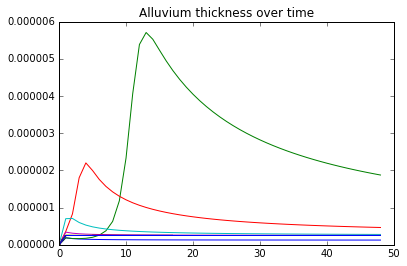

In [95]:
%matplotlib inline

for i in range(num_time_steps):
    # calculate slope
    S = (z[upper] - z[1:]) / dx
    
    # calculate Es and Er using H from previous time step?
    Es = Ks * q[upper] * S * (1.0 - np.exp(-H[upper] / Hstar))
    
    Er = Kr * q[upper] * S * np.exp(-H[upper] / Hstar)
    
    for j in range (num_nodes - 1):
        # calculate qs from H of previous time step
        qs[j] = (((Es[j]) + (1-Ff) * Er[j]) / Voverq[j]) * (1.0 - np.exp(-dx * Voverq[j])) + (qs_in[j] * np.exp(-dx * Voverq[j]))
        qs_in[j+1] = qs[j]
        
        # Update D (Vqs/q) and t'
        
        Dep_rate[j] = V * (qs[j]/q[j])
        D[j] = Dep_rate[j] / (Ks * q[j] * S[j])
        tprime = (t[j] * Hstar) / (Ks * q[j] * S[j])        
        
        # calculate H using the qs that was just found?
        # calculate it using the analtical solution outlined above.
        # have to put in an if statement about whether D = 1 ?
        
        if D[j] == 0:
            H[j] = np.log(dt + np.exp(H[j-1]))
        else:
            H[j] = Hstar * np.log((1/(D[j]-1))* (np.exp(((Dep_rate[j] - Ks*q[j]*S[j])*tprime) / Hstar) * ((D[j]-1) * np.exp(H[j-1]/Hstar) + 1) - 1)) 
            
    # not doing an analytical solution for R (?)    
    R[upper] += dt * (U - Kr * q[upper] * S * (np.exp(-H[upper] / Hstar)))
    
    if i % 100 == 0:
        plt.plot(H[:-1])
        plt.title('Alluvium thickness over time')
    
    z = R + H


[  0.00000000e+00   2.49844088e-07   2.49965438e-07   2.50013079e-07
   2.50035409e-07   2.50046821e-07   2.50052846e-07   2.50055969e-07
   2.50057433e-07   2.50057909e-07   2.50057782e-07   2.50057282e-07
   2.50056550e-07   2.50055678e-07   2.50054723e-07   2.50053725e-07
   2.50052709e-07   2.50051693e-07   2.50050687e-07   2.50049700e-07
   2.50048736e-07   2.50047798e-07   2.50046887e-07   2.50046006e-07
   2.50045153e-07   2.50044329e-07   2.50043533e-07   2.50042764e-07
   2.50042022e-07   2.50041306e-07   2.50040613e-07   2.50039945e-07
   2.50039299e-07   2.50038675e-07   2.50038071e-07   2.50037487e-07
   2.50036922e-07   2.50036375e-07   2.50035845e-07   2.50035332e-07
   2.50034834e-07   2.50034352e-07   2.50033884e-07   2.50033429e-07
   2.50032988e-07   2.50032560e-07   2.50032143e-07   2.50031738e-07
   2.50031344e-07   0.00000000e+00]
47999879.9851


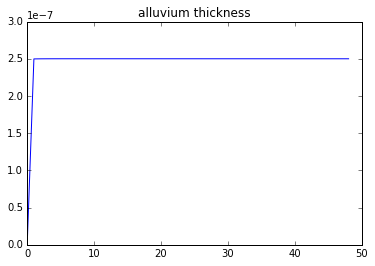

In [96]:
plt.plot(H[:-1])
plt.title('alluvium thickness')
print H
print tprime

In [97]:
H

array([  0.00000000e+00,   2.49844088e-07,   2.49965438e-07,
         2.50013079e-07,   2.50035409e-07,   2.50046821e-07,
         2.50052846e-07,   2.50055969e-07,   2.50057433e-07,
         2.50057909e-07,   2.50057782e-07,   2.50057282e-07,
         2.50056550e-07,   2.50055678e-07,   2.50054723e-07,
         2.50053725e-07,   2.50052709e-07,   2.50051693e-07,
         2.50050687e-07,   2.50049700e-07,   2.50048736e-07,
         2.50047798e-07,   2.50046887e-07,   2.50046006e-07,
         2.50045153e-07,   2.50044329e-07,   2.50043533e-07,
         2.50042764e-07,   2.50042022e-07,   2.50041306e-07,
         2.50040613e-07,   2.50039945e-07,   2.50039299e-07,
         2.50038675e-07,   2.50038071e-07,   2.50037487e-07,
         2.50036922e-07,   2.50036375e-07,   2.50035845e-07,
         2.50035332e-07,   2.50034834e-07,   2.50034352e-07,
         2.50033884e-07,   2.50033429e-07,   2.50032988e-07,
         2.50032560e-07,   2.50032143e-07,   2.50031738e-07,
         2.50031344e-07,

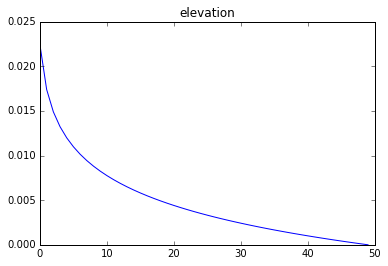

In [98]:
plt.plot(z)
plt.title('elevation')

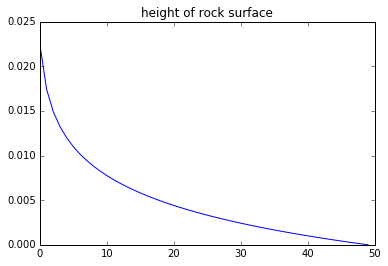

In [99]:
plt.plot(R)
plt.title('height of rock surface')